# CarND-Vehicle-Detection

**Vehicle Detection Project**

The steps of this project are the following:

* Perform Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Also applied a color transform and append binned color features, as well as histograms of color, to HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
# ## vehicle data download
# !wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# !unzip vehicles.zip data/

In [2]:
# ## non vehicle data download
# !wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
# !unzip non-vehicles.zip data/

Vehicle detection using Feature extraction and machine learning linear SVM classifier

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob, os
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

### Functions for Extracting features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# def color_hist(img, nbins=32, bins_range=(0, 256)):
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),hist_bins=32, orient=9,pix_per_cell=8, cell_per_block=2, hog_channel=0, \
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins )
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [6]:

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, \
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    global feature_dim_check
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        if feature_dim_check==True:
            print("no. of spatial features: ", spatial_features.shape)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        if feature_dim_check==True:
            print("no. of color histogram features: ", hist_features.shape)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        if feature_dim_check==True:
            print("no. of HOG features: ", hog_features.shape)
    #9) Return concatenated array of features
    feature_dim_check=False
    return np.concatenate(img_features)

In [7]:
### Tweaked parameters to see how the results change.
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 16    # Number of histogram bins
hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [400, 700] # Min and max in y to search in slide_window()

## Data reading and analysis

In [8]:
# Read in cars and notcars

# images_vehicle = glob.glob('data/vehicles/*/*.png', recursive='True')
# print("no of file in car image folder: ",len(images_vehicle))
# cars = []
# for image in images_vehicle:
#     cars.append(image)
cars = glob.glob('data/vehicles/*/*.png', recursive='True')
print("no. of image file in car image folder: ",len(cars))

# images_non_vehicle = glob.glob('data/non-vehicles/*/*.png', recursive='True')
# # print("no of file in not-car image folder: ",len(images_non_vehicle))
# notcars = []
# for image in images_non_vehicle:
#     notcars.append(image)

notcars = glob.glob('data/non-vehicles/*/*.png', recursive='True')
print("no. of image file in non-car image folder: ",len(notcars))

no. of image file in car image folder:  8792
no. of image file in non-car image folder:  8968


D:\installation\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
D:\installation\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)
D:\installation\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:17: RuntimeWarning: invalid value encountered in minimum
  out = np.minimum(out, 0.2)


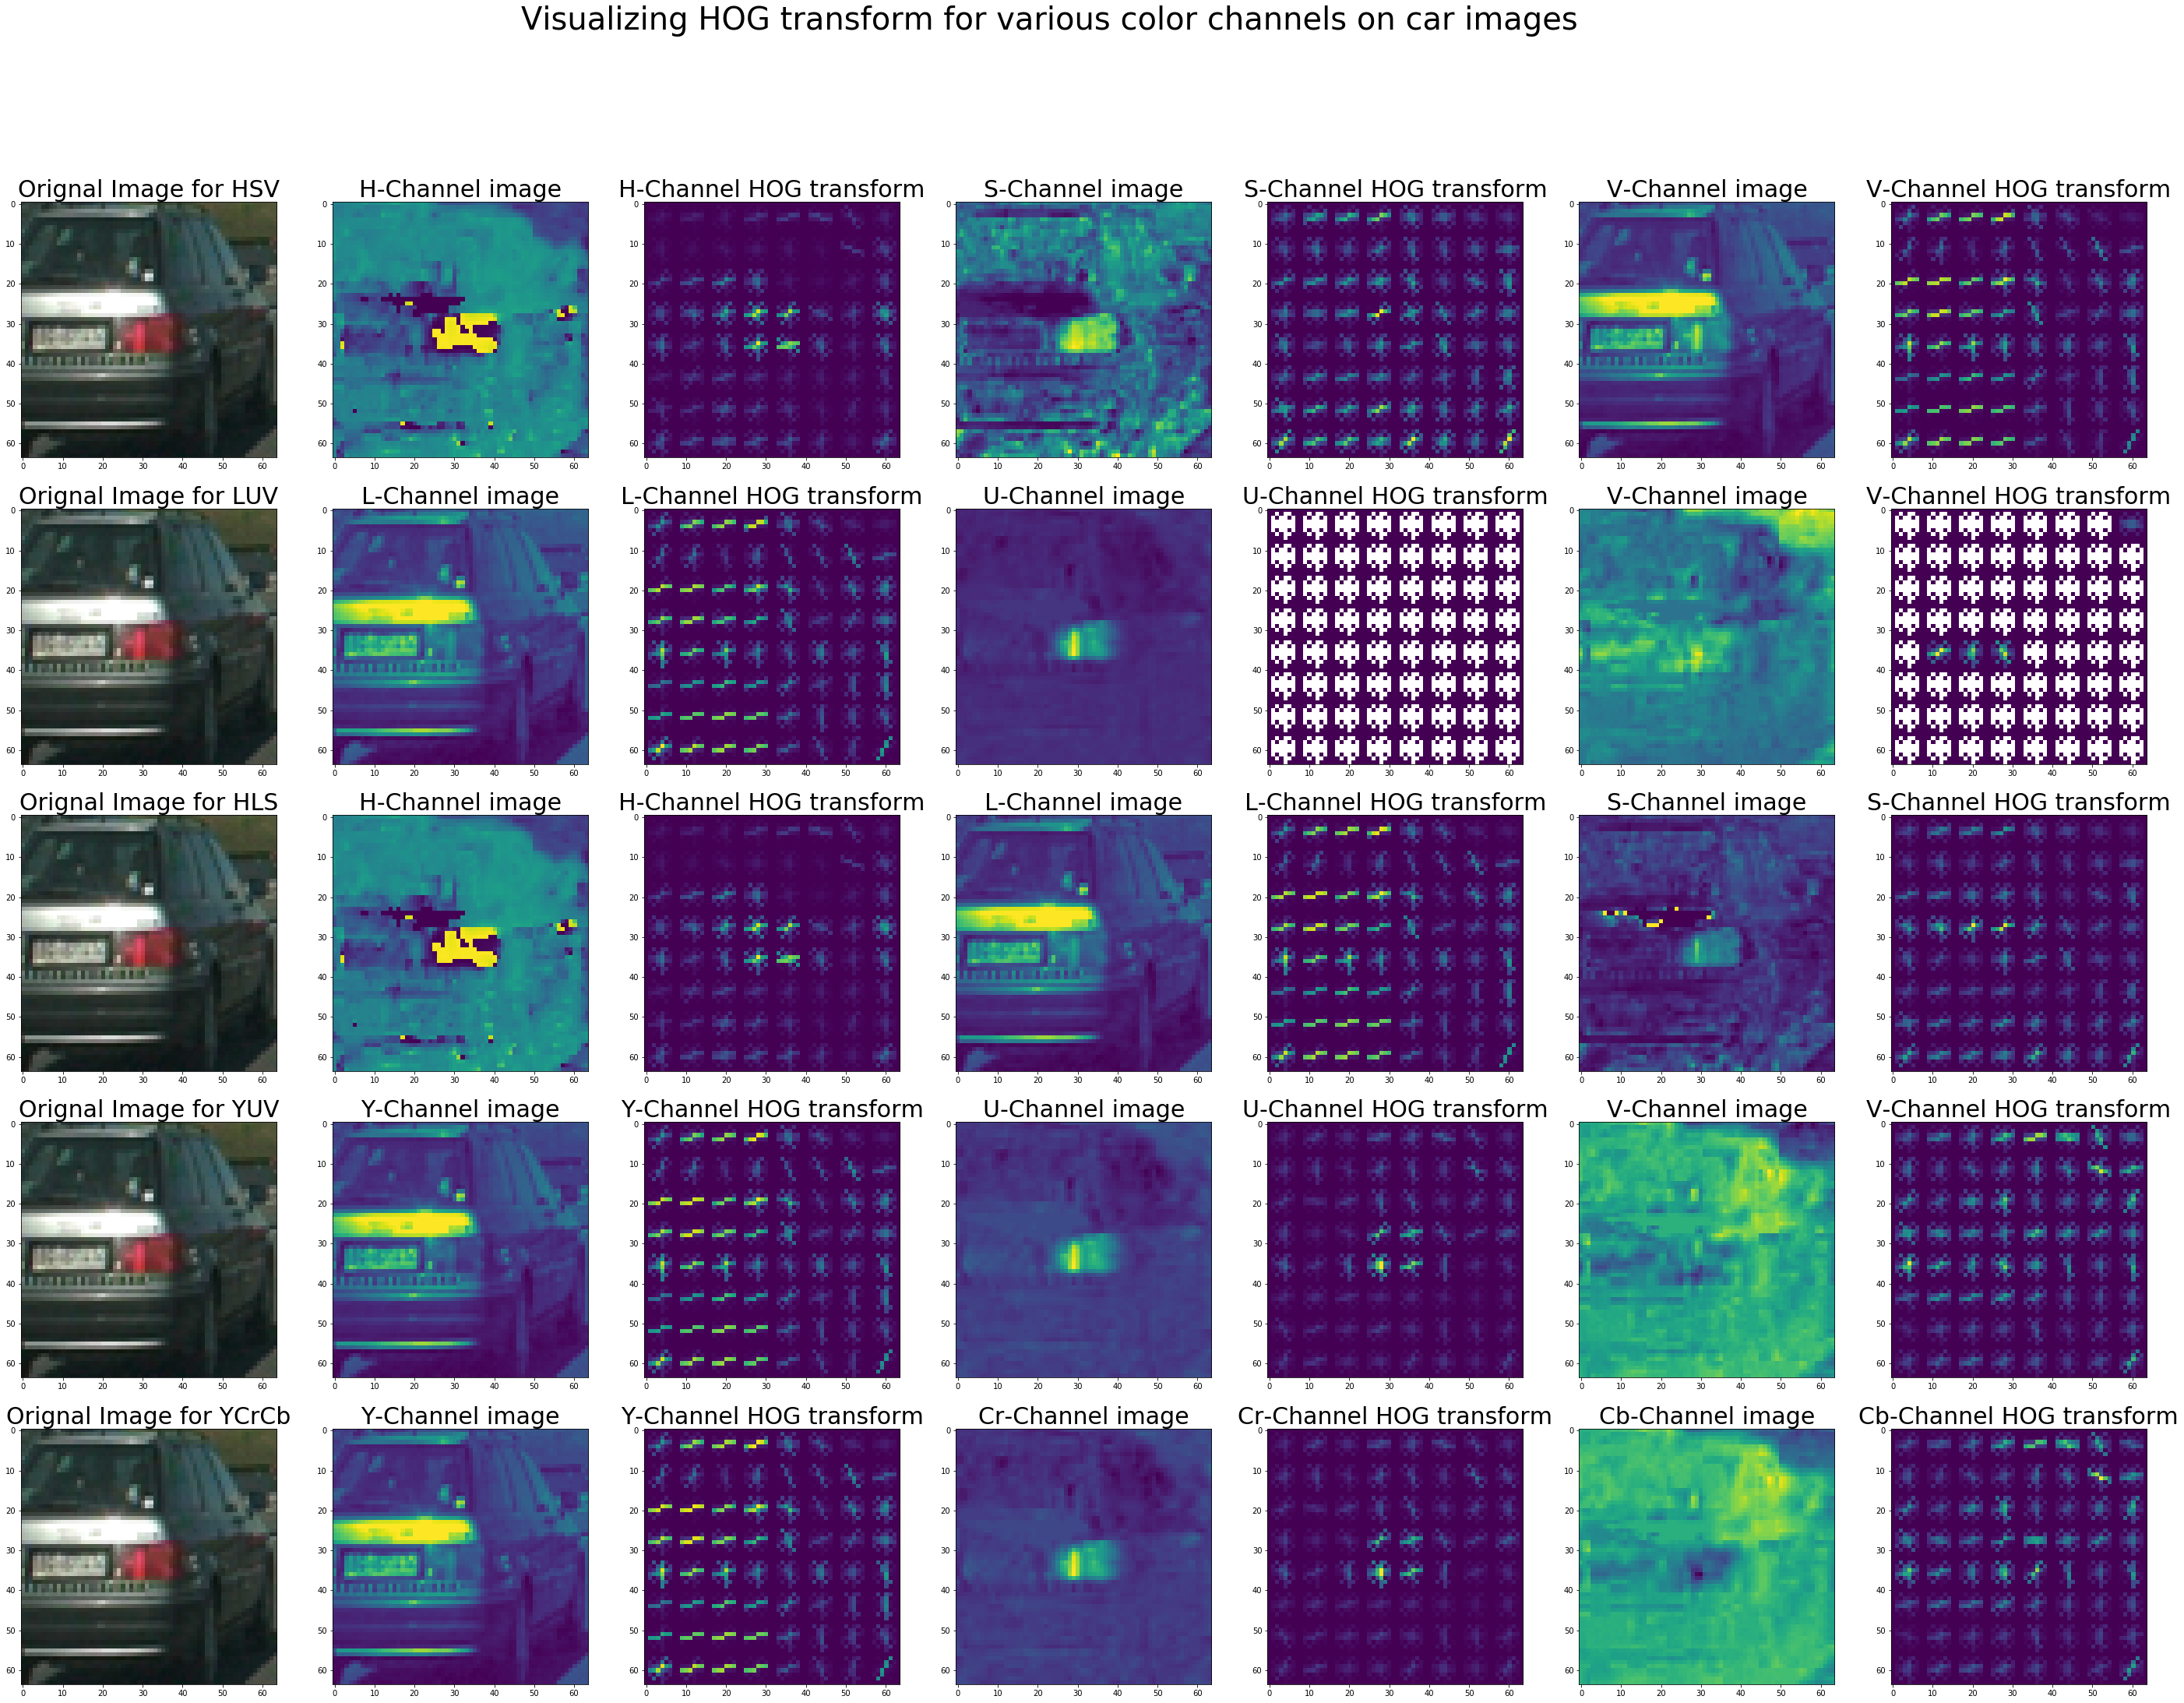

In [9]:
## visualizing HOG for car data

img_idx = 1005
car_img = cars[img_idx]
img = mpimg.imread(car_img)
color_ch = [[cv2.COLOR_RGB2HSV, "H", "S", "V"],
           [cv2.COLOR_RGB2LUV, "L", "U", "V"],
           [cv2.COLOR_RGB2HLS, "H", "L", "S"],
           [cv2.COLOR_RGB2YUV, "Y", "U", "V"],
           [cv2.COLOR_RGB2YCrCb, "Y", "Cr", "Cb"]]
plt_rows= len(color_ch)
plt_columns = 7
fig = plt.figure(figsize=(7*plt_columns,7*plt_rows))
fig.suptitle('Visualizing HOG transform for various color channels on car images', fontsize=40)
fontsize=30
for i in range(plt_rows):
    feature_image = cv2.cvtColor(img, color_ch[i][0])
    _,hog_img_0 = get_hog_features(feature_image[:,:,0],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    _,hog_img_1 = get_hog_features(feature_image[:,:,1],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    _,hog_img_2 = get_hog_features(feature_image[:,:,2],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+1 )
    plt.imshow(img)
    plt.title("Orignal Image for "+color_ch[i][1]+color_ch[i][2]+color_ch[i][3], fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+2 )
    plt.imshow(feature_image[:,:,0])
    plt.title(color_ch[i][1] + "-Channel image", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+3 )
    plt.imshow(hog_img_0)
    plt.title(color_ch[i][1] + "-Channel HOG transform", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+4 )
    plt.imshow(feature_image[:,:,1])
    plt.title(color_ch[i][2] + "-Channel image", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+5 )
    plt.imshow(hog_img_1)
    plt.title(color_ch[i][2] + "-Channel HOG transform", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+6 )
    plt.imshow(feature_image[:,:,2])
    plt.title(color_ch[i][3] + "-Channel image", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+7 )
    plt.imshow(hog_img_2)
    plt.title(color_ch[i][3] + "-Channel HOG transform", fontsize =fontsize)

# fig.savefig("HOG_car.jpg")   

D:\installation\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
D:\installation\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)
D:\installation\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:17: RuntimeWarning: invalid value encountered in minimum
  out = np.minimum(out, 0.2)


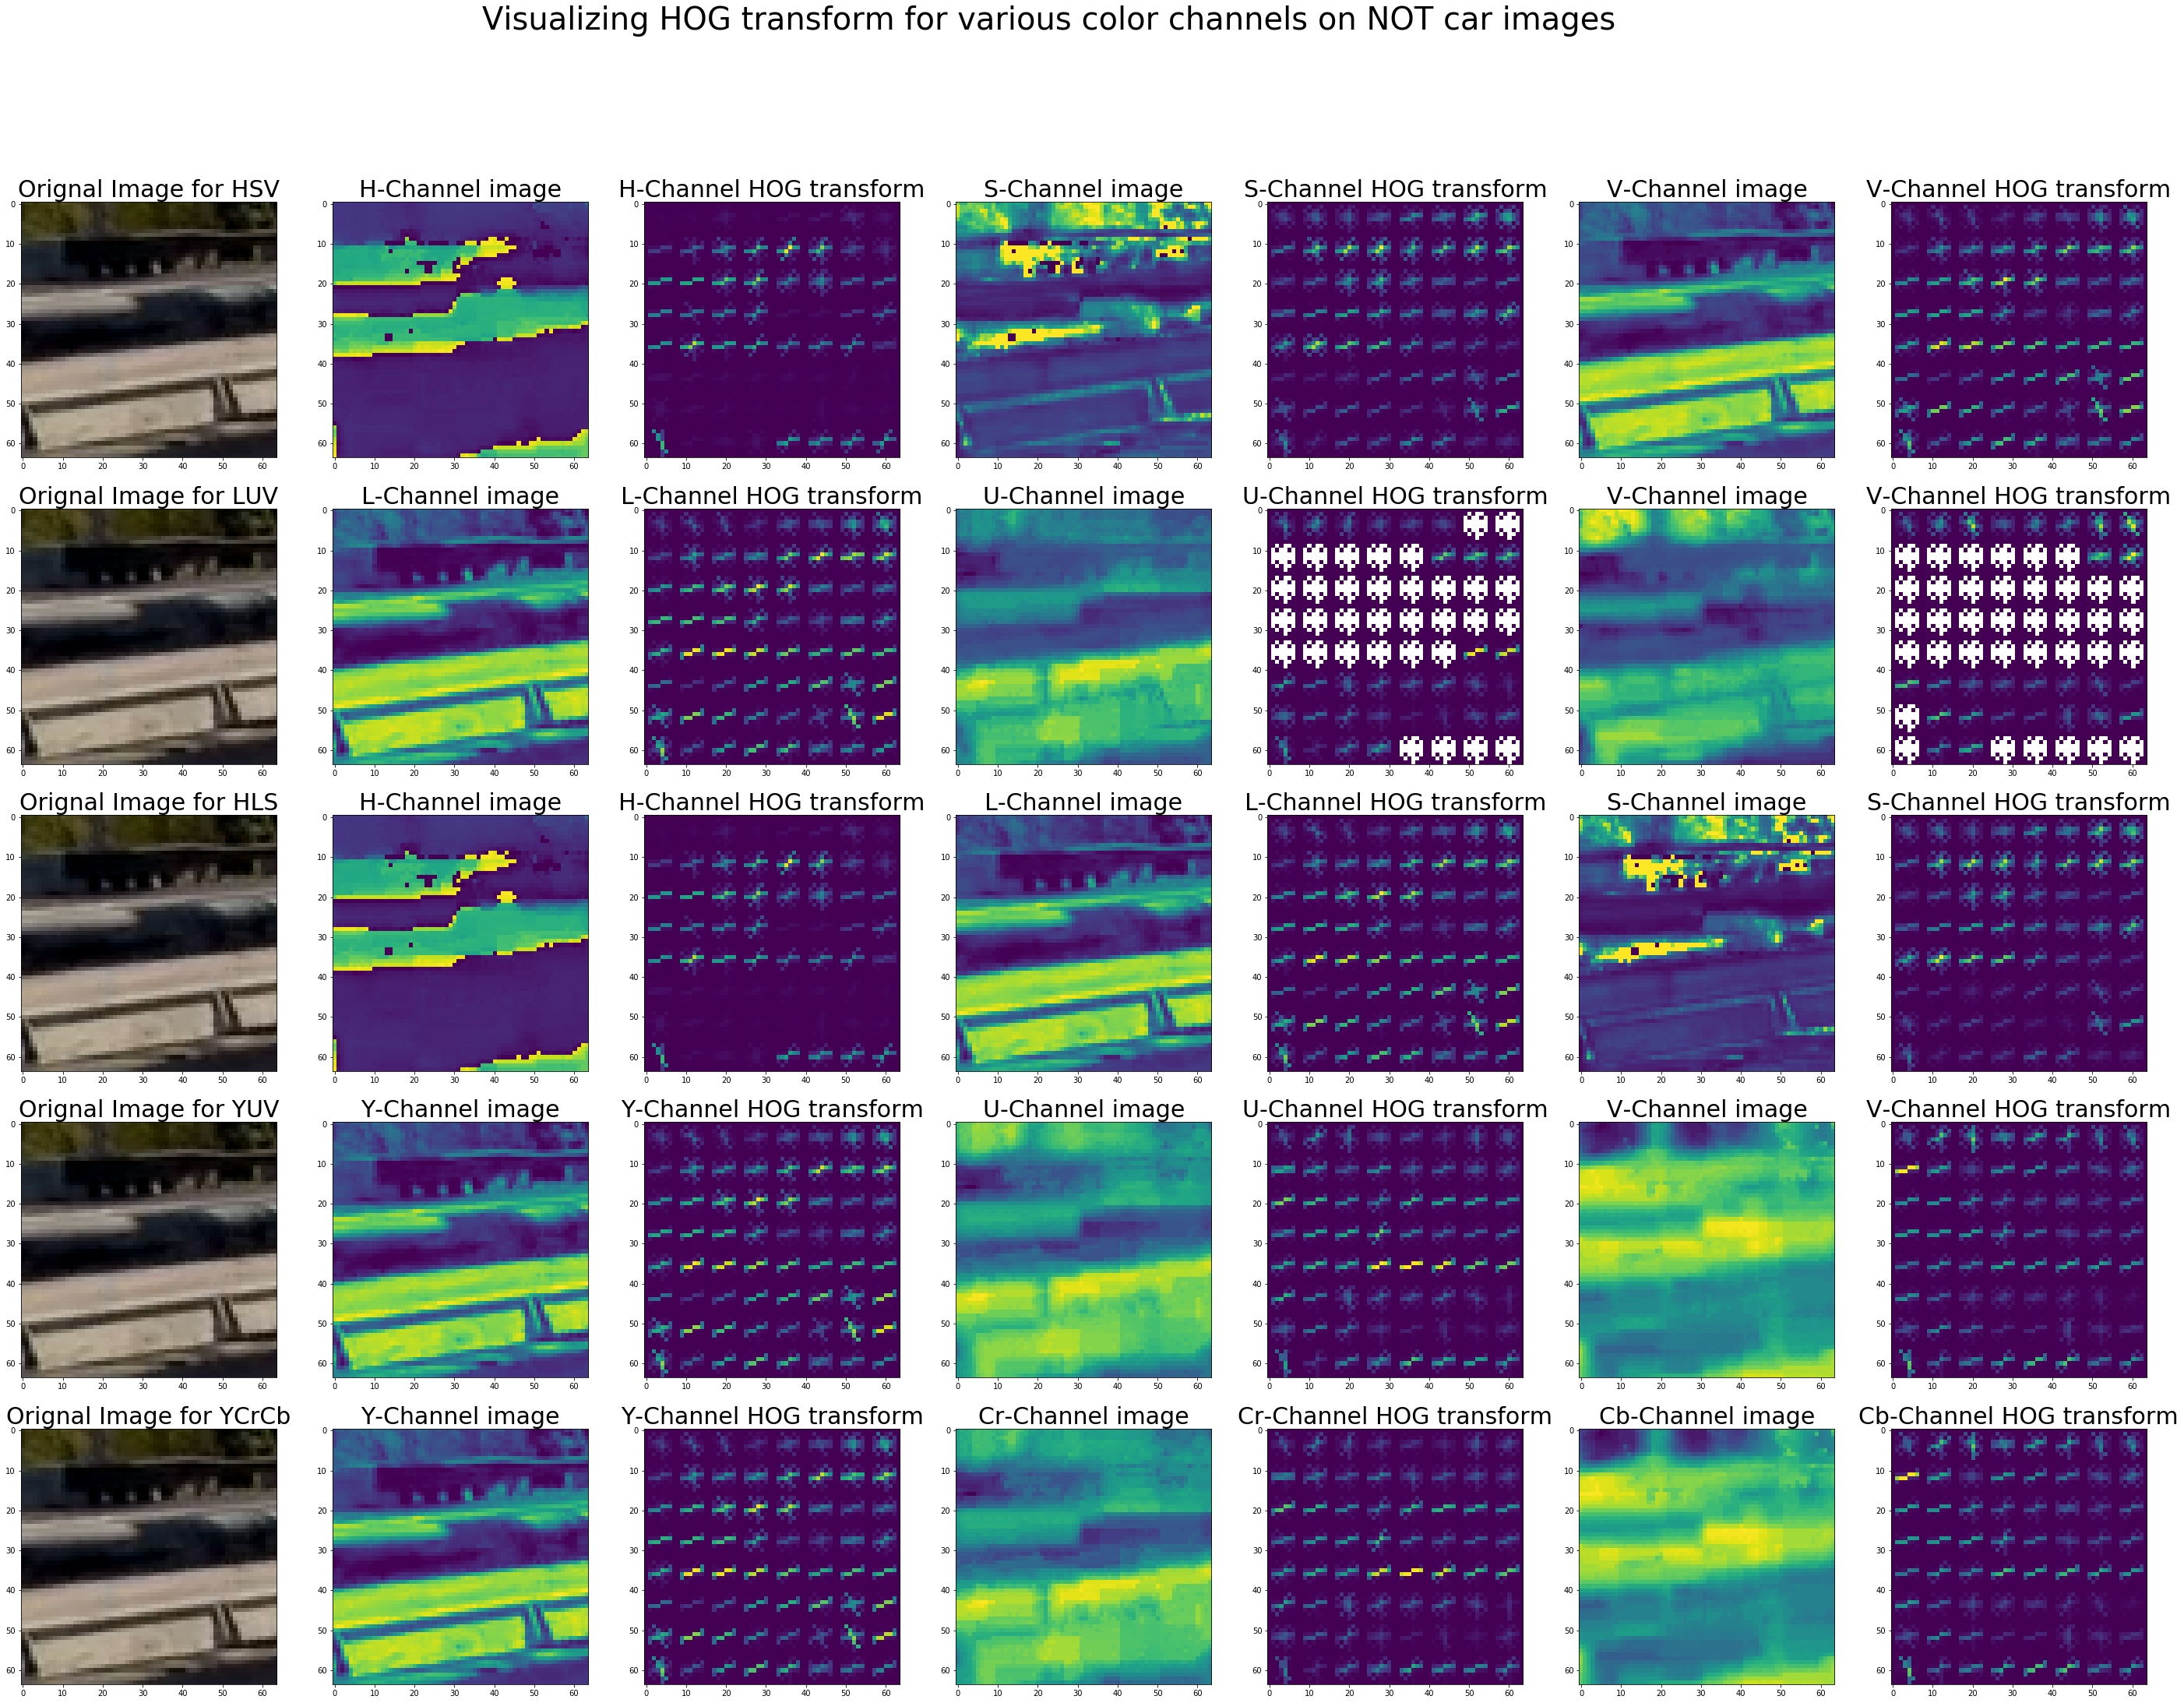

In [10]:
## visualizing HOG for not-car data

img_idx = 2005
notcar_img = notcars[img_idx]
img = mpimg.imread(notcar_img)
fig = plt.figure(figsize=(7*plt_columns,7*plt_rows))
fig.suptitle('Visualizing HOG transform for various color channels on NOT car images', fontsize=40)
for i in range(plt_rows):
    feature_image = cv2.cvtColor(img, color_ch[i][0])
    _,hog_img_0 = get_hog_features(feature_image[:,:,0],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    _,hog_img_1 = get_hog_features(feature_image[:,:,1],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    _,hog_img_2 = get_hog_features(feature_image[:,:,2],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+1 )
    plt.imshow(img)
    plt.title("Orignal Image for "+color_ch[i][1]+color_ch[i][2]+color_ch[i][3], fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+2 )
    plt.imshow(feature_image[:,:,0])
    plt.title(color_ch[i][1] + "-Channel image", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+3 )
    plt.imshow(hog_img_0)
    plt.title(color_ch[i][1] + "-Channel HOG transform", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+4 )
    plt.imshow(feature_image[:,:,1])
    plt.title(color_ch[i][2] + "-Channel image", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+5 )
    plt.imshow(hog_img_1)
    plt.title(color_ch[i][2] + "-Channel HOG transform", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+6 )
    plt.imshow(feature_image[:,:,2])
    plt.title(color_ch[i][3] + "-Channel image", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+7 )
    plt.imshow(hog_img_2)
    plt.title(color_ch[i][3] + "-Channel HOG transform", fontsize =fontsize)

# fig.savefig("HOG_NOT_car.jpg")  

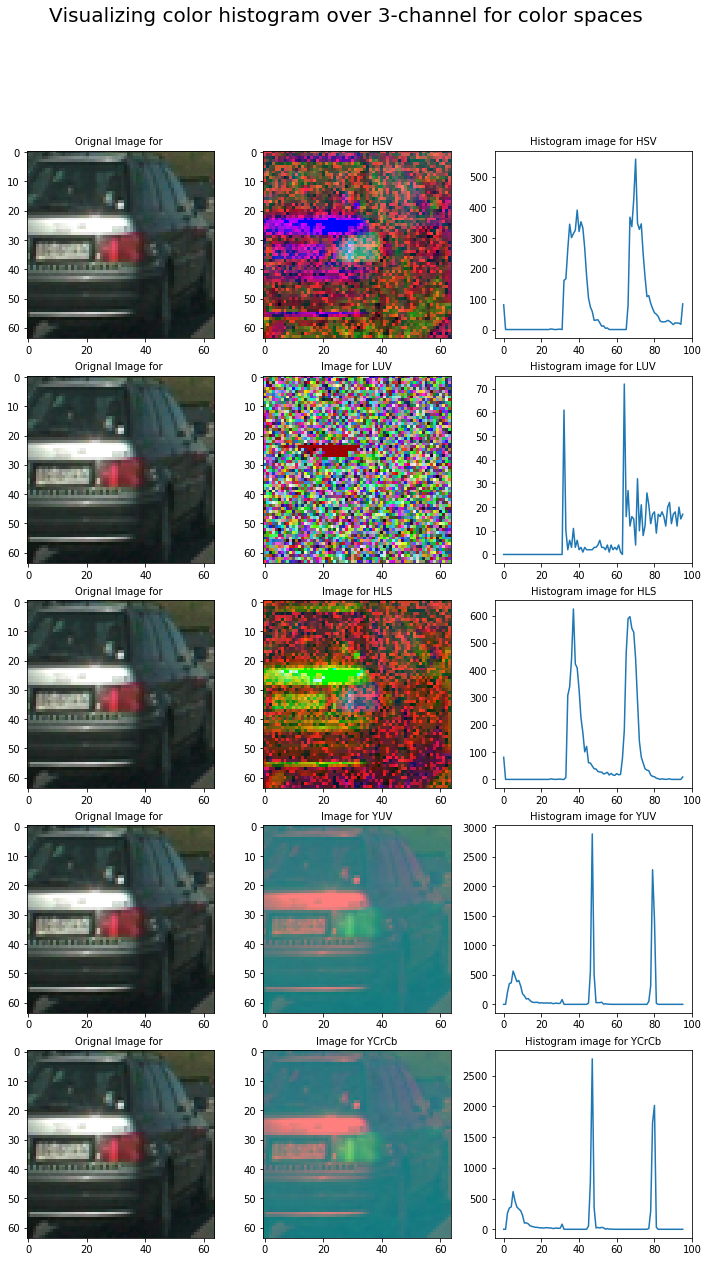

In [11]:
### histogram of color for car images

img_idx = 1005
car_img = cars[img_idx]
img = mpimg.imread(car_img)
plt_rows= len(color_ch)
plt_columns = 3
fig = plt.figure(figsize=(4*plt_columns,4*plt_rows))
fig.suptitle('Visualizing color histogram over 3-channel for color spaces', fontsize=20)
fontsize=10
for i in range(plt_rows):
    feature_image = cv2.cvtColor(img, color_ch[i][0])
    col_hist = color_hist(feature_image, nbins=32, bins_range=(0, 1))
    plt.subplot(plt_rows, plt_columns, plt_columns*i+1 )
    plt.imshow(img)
    plt.title("Orignal Image for ", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+2 )
    plt.imshow(feature_image)
    plt.title("Image for " + color_ch[i][1]+color_ch[i][2]+color_ch[i][3], fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+3 )
    plt.plot(col_hist)
    plt.title("Histogram image for " +color_ch[i][1]+color_ch[i][2]+color_ch[i][3], fontsize =fontsize)


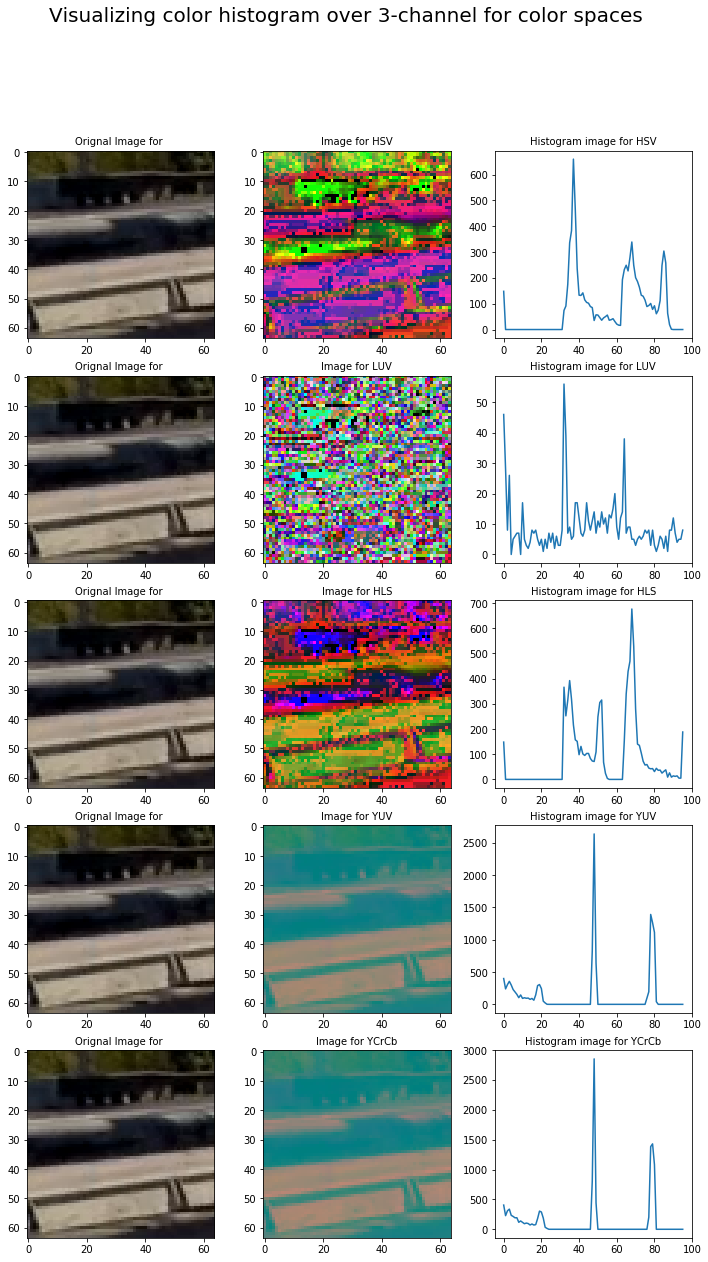

In [12]:
### histogram of color for NOT car images
img_idx = 2005
notcar_img = notcars[img_idx]
img = mpimg.imread(notcar_img)
plt_rows= len(color_ch)
plt_columns = 3
fig = plt.figure(figsize=(4*plt_columns,4*plt_rows))
fig.suptitle('Visualizing color histogram over 3-channel for color spaces', fontsize=20)
fontsize=10
for i in range(plt_rows):
    feature_image = cv2.cvtColor(img, color_ch[i][0])
    col_hist = color_hist(feature_image, nbins=32, bins_range=(0, 1))
    plt.subplot(plt_rows, plt_columns, plt_columns*i+1 )
    plt.imshow(img)
    plt.title("Orignal Image for ", fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+2 )
    plt.imshow(feature_image)
    plt.title("Image for " + color_ch[i][1]+color_ch[i][2]+color_ch[i][3], fontsize =fontsize)
    plt.subplot(plt_rows, plt_columns, plt_columns*i+3 )
    plt.plot(col_hist)
    plt.title("Histogram image for " +color_ch[i][1]+color_ch[i][2]+color_ch[i][3], fontsize =fontsize)


### Data preperation

In [13]:
%%time
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("car_features shape: ", car_features[0].shape)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat )
print("notcar_features shape: ", notcar_features[0].shape)
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print("X shape: ", X.shape)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("y shape: ", y.shape)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

car_features shape:  (4932,)
notcar_features shape:  (4932,)
X shape:  (17760, 4932)
y shape:  (17760,)
Wall time: 2min 25s


## Train the classifier

In [14]:
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# svc = LinearSVC()
svc = LinearSVC(verbose =1)
# svc = SVC(verbose = 1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
clf = svc

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
[LibLinear]

D:\installation\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


43.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9761


In [15]:
## Save Model 
import pickle
# pickle.dumps(clf)
clf_v1 = {}
clf_v1["clf"] = clf
clf_v1["X_scaler"] = X_scaler
with open( "svm_classifier.p", "wb" ) as file1: 
    pickle.dump(clf_v1, file1 )

## Frame processing

In [16]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [17]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,   \
                            spatial_size=spatial_size, hist_bins=hist_bins, \
                            orient=orient, pix_per_cell=pix_per_cell, \
                            cell_per_block=cell_per_block,  \
                            hog_channel=hog_channel, spatial_feat=spatial_feat,  \
                            hist_feat=hist_feat, hog_feat=hog_feat)
#         print(features.shape)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
  

In [18]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [19]:
### Heat map functions

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


### Use predict using classifier on bounding boxes

In [20]:
## Load Model
import pickle
clf_load  = pickle.load( open( "svm_classifier.p", "rb" ) )
clf = clf_load["clf"]
X_scaler = clf_load["X_scaler"]

no. of spatial features:  (3072,)
no. of color histogram features:  (96,)
no. of HOG features:  (1764,)
Wall time: 39.2 s


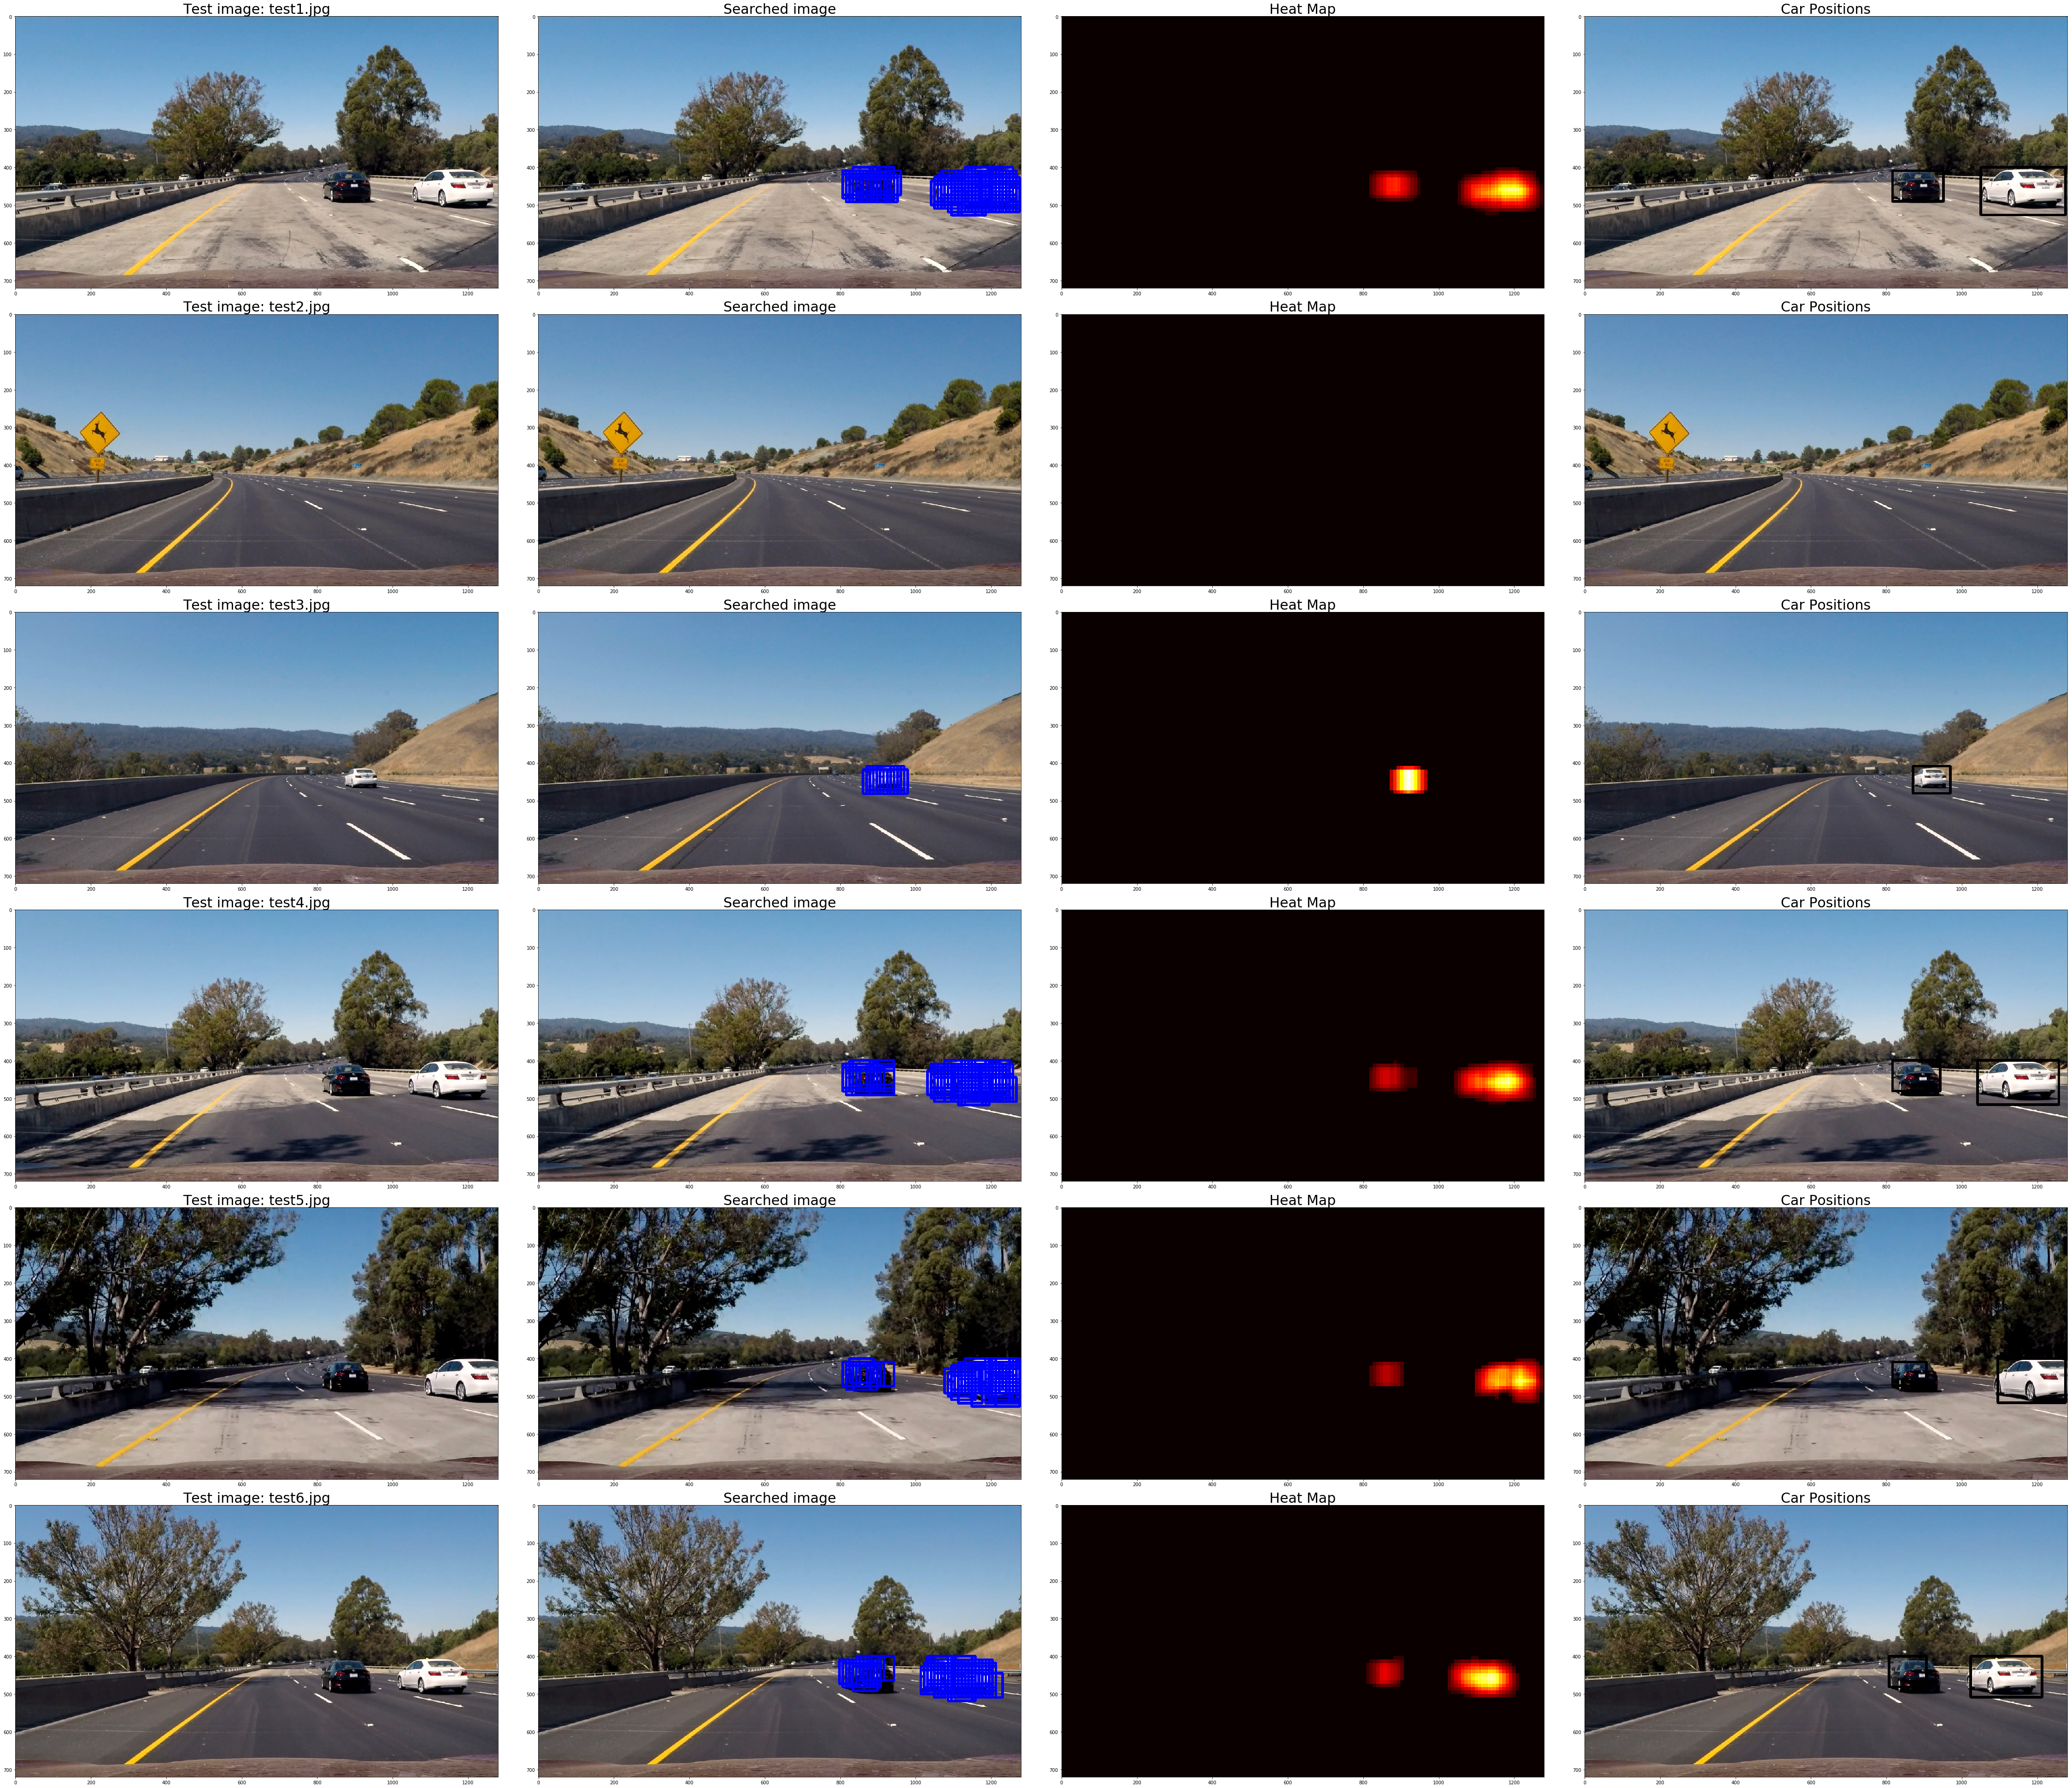

In [21]:
%%time
#  Prediction for a single frame
global feature_dim_check
feature_dim_check = True
test_images = glob.glob("test_images/*.jpg")
# test_images = ["bbox-example-image.jpg"]
no_imgs= len(test_images)
plt_columns = 4
fig = plt.figure(figsize=(16*plt_columns,9*no_imgs))
fontsize =30
# hot_windows_list = []
for i, img_file in enumerate(test_images):
    image = mpimg.imread(img_file)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    # windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 760],  \
    #                     xy_window=(64, 64), xy_overlap=(0.5, 0.5))
#     windows1 = slide_window(image, x_start_stop=[750, None], y_start_stop=[400, 528+1],  \
#                         xy_window=(64, 64), xy_overlap=(0.85, 0.85))
#     windows2 = slide_window(image, x_start_stop=[770, None], y_start_stop=[510, 610+1],  \
#                         xy_window=(96, 96), xy_overlap=(0.8, 0.8))
#     windows3 = slide_window(image, x_start_stop=[800, None], y_start_stop=[500, 756+1],  \
#                         xy_window=(128, 128), xy_overlap=(0.7, 0.7))


    windows1 = slide_window(image, x_start_stop=[600,None], y_start_stop=[400, 528+1],  \
                        xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    windows2 = slide_window(image, x_start_stop=[600, None], y_start_stop=[510, 610+1],  \
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    windows3 = slide_window(image, x_start_stop=[600, None], y_start_stop=[500, 756+1],  \
                        xy_window=(128, 128), xy_overlap=(0.7, 0.7))
    
    windows = windows1 + windows2 + windows3
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space,  \
                            spatial_size=spatial_size, hist_bins=hist_bins, \
                            orient=orient, pix_per_cell=pix_per_cell, \
                            cell_per_block=cell_per_block, \
                            hog_channel=hog_channel, spatial_feat=spatial_feat, \
                            hist_feat=hist_feat, hog_feat=hog_feat)  
    
#     print("no. of search Windows: ",len(windows))
#     print("no. of Hot windows: ",len(hot_windows))
    window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)   
    hot_window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
#     print(labels[1])
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

# plt.figure(figsize=(16,9))
    plt.subplot(no_imgs,plt_columns, plt_columns*i+1)
    plt.imshow(image)
#     plt.imshow(window_img)
    plt.title("Test image: "+ os.path.basename(img_file), fontsize = fontsize)
    plt.subplot(no_imgs,plt_columns, plt_columns*i+2)
    plt.imshow(hot_window_img)
    plt.title('Searched image', fontsize = fontsize)
    plt.subplot(no_imgs,plt_columns, plt_columns*i+3)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map', fontsize = fontsize)
    plt.subplot(no_imgs,plt_columns, plt_columns*i+4)
    plt.imshow(draw_img)
    plt.title('Car Positions', fontsize = fontsize)
    fig.tight_layout()
    
# fig.savefig("Test_frame_w_HeatMaps.jpg")

# Video Processing

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
def pipeline_image_processing(image):
    global averging_over_frames, no_frame_avg, heat_threshold
    
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    windows1 = slide_window(image, x_start_stop=[750, None], y_start_stop=[400, 528],  \
                        xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    windows2 = slide_window(image, x_start_stop=[770, None], y_start_stop=[510, 610],  \
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    windows3 = slide_window(image, x_start_stop=[800, None], y_start_stop=[500, 756],  \
                        xy_window=(128, 128), xy_overlap=(0.7, 0.7))

    windows = windows1 + windows2 + windows3
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space,  \
                            spatial_size=spatial_size, hist_bins=hist_bins, \
                            orient=orient, pix_per_cell=pix_per_cell, \
                            cell_per_block=cell_per_block, \
                            hog_channel=hog_channel, spatial_feat=spatial_feat, \
                            hist_feat=hist_feat, hog_feat=hog_feat) 
    
    averging_over_frames.append(hot_windows)
    if len(averging_over_frames) > no_frame_avg:
            averging_over_frames.pop(0)
    hot_avg = []
    for frame_window in averging_over_frames :
        hot_avg +=frame_window
          
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    avg_window_img = draw_boxes(draw_image, hot_avg, color=(0, 0, 255), thick=6)
    ### heat map code
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
#     heat = add_heat(heat,hot_windows)
    heat = add_heat(heat,hot_avg)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)
#     heat = apply_threshold(heat,len(averging_over_frames))

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255).astype(int)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    result = draw_img
    
        # Overlay pipline stages
    imshape = image.shape 
    overlay_col_size = int(imshape[1]/3)
    overlay_row_size = int(imshape[0]/3)
    # resizing to fit smaller window
    window_img_resized = cv2.resize(window_img, (overlay_col_size, overlay_row_size ))
    avg_window_img_resized = cv2.resize(avg_window_img, (overlay_col_size, overlay_row_size ))
#     heatmap_avg_resized = cv2.resize(heatmap, (overlay_col_size, overlay_row_size ))
    
    # adding current window to final output, with image label
    cv2.putText(result, "Current Window in image", (25, 20),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    result[30:overlay_row_size + 30, 10:overlay_col_size +10 ]  \
    = window_img_resized          
    
    
    # adding window to final output, with image label
    cv2.putText(result, "Total windows for Avg", (overlay_col_size + 35, 20),\
                cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    result[30:overlay_row_size + 30,  overlay_col_size + 20: 2*overlay_col_size +20 ]  \
    = avg_window_img_resized

 
    cv2.putText(result, "Total Search Windows: {}".format(len(windows)), (int((result.shape[1])*0.65)+50, 50),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    cv2.putText(result, "Hot windows : {}".format(len(hot_windows)), (int((result.shape[1])*0.65)+50, 75),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    cv2.putText(result, "Hot windows over past {} frames : {}".format(len(averging_over_frames), len(hot_avg)), (int((result.shape[1])*0.65)+50, 90),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    cv2.putText(result, "Number of Car: {}".format(labels[1]), (int((result.shape[1])*0.65)+50, 115),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    
    return result


In [24]:
global averging_over_frames, no_frame_avg, feature_dim_check, heat_threshold
feature_dim_check = False
averging_over_frames = []  #queue to store lane coordintes for averaging over no. of frames(given by 'no_frame_avg')
no_frame_avg = 20  # this indicate the number on frames to average the lanes over
heat_threshold = 50
# vid_output = "project_VD_output_svm2_LinKernal_YCrCb_32x32_hist32_HOG_Y_thr_" + str(heat_threshold) + "_avg_" + str(no_frame_avg) + ".mp4"
vid_output = "project_video_output.mp4"
# clip1 = VideoFileClip("project_video.mp4").subclip(10,12)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline_image_processing) #NOTE: this function expects color images!!

%time output_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_VD_output_svm2_LinKernal_YCrCb_32x32_hist32_HOG_Y_thr_50_avg_20.mp4
[MoviePy] Writing video project_VD_output_svm2_LinKernal_YCrCb_32x32_hist32_HOG_Y_thr_50_avg_20.mp4


100%|█████████████████████████████████████▉| 1260/1261 [43:14<00:02,  2.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_VD_output_svm2_LinKernal_YCrCb_32x32_hist32_HOG_Y_thr_50_avg_20.mp4 

Wall time: 43min 18s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))